# Bangumi个人记录

## 导入分析库

In [1]:
%%time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

Wall time: 1.85 s


## 已看番剧词云图
### 1. 相关函数

In [2]:
def get_html_content_in_text(url):
    """
    Grab all the content in webpage url and return it's content in text.
    
    Arguments:
    url -- a webpage url string.
    
    Returns:
    r.text -- the content of webpage in text.
    
    """
    r = requests.get(url)
    r.encoding = r.apparent_encoding
    return r.text

In [3]:
def get_title(soup):
    """
    Grab all the Chinese title and Japanese title.
    
    Arguments:
    soup -- a BeautifulSoup object.
    
    Returns:
    title_chinese -- a list of title in chinese.
    title_japanese -- a list of title in japanses.
    
    """
    title = soup.find_all('h3')
    title_chinese = []
    title_japanese = []
    title_link = []
    for i in title:
        if i.a and i.small:
            title_chinese.append(i.a.string)
            title_japanese.append(i.small.string)
            title_link.append('http://bangumi.tv' + i.a.get('href'))
        else:
            if i.a:
                title_chinese.append(i.a.string)
                title_link.append('http://bangumi.tv' + i.a.get('href'))
                title_japanese.append('None')
            else:
                title_chinese.append('None')
                title_japanese.append(i.small.string)
    return title_chinese, title_japanese, title_link

In [4]:
def get_star(soup):
    """
    Grab all the star.
    
    Arguments:
    soup -- a BeautifulSoup object.
    
    Returns:
    star_count -- a list of star value.
    
    """
    star_list = soup.find_all(class_='collectInfo')
    star_count = []
    for star in list(star_list):
        star_search = re.search(r'sstars(.*) starsinfo',str(star), re.IGNORECASE)
        if star_search:
            star_count.append(int(star_search.group(1)))
        else:
            star_count.append(None)
    return star_count

In [5]:
def make_wordcloud_plot(df, word_column, value_column, colormap='plasma',max_font_size=50, width=1400, height=1400,max_words=2000, size=25):
    d = df.to_dict('index')
    dict_for_plot = {}
    for i in d.values():
        try:
            dict_for_plot[i[word_column]] = int(i[value_column])
        except ValueError:
            pass
    
    font = r'C:\Windows\Fonts\SimHei.ttf'
    wordcloud = WordCloud(font_path=font, 
                          width=1400, 
                          height=1400, 
                          background_color='white',
                          max_words=2000,
                          max_font_size=50, 
                          colormap=colormap,
                          mode='RGBA').fit_words(dict_for_plot)
    
    plt.figure(figsize=(size,size))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### 2. 拉取记录

In [6]:
%%time
title_chinese_total = []
title_japanese_total = []
title_link_total = []
star_count_total = []

i = 1
print('正在获取页面记录：')
while True:
    content = get_html_content_in_text('http://bangumi.tv/anime/list/infinityloop/collect?page='+str(i))
    soup = BeautifulSoup(content, "html5lib")

    title_chinese, title_japanese, title_link = get_title(soup)
    star_count = get_star(soup)

    if len(title_chinese) != 0:
        print(i,' ', end='')
        title_chinese_total.extend(title_chinese)
        title_japanese_total.extend(title_japanese)
        title_link_total.extend(title_link)
        star_count_total.extend(star_count)
        i += 1
    else:
        break

正在获取页面记录：
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  Wall time: 29.6 s


In [7]:
df = pd.DataFrame({'chinese':title_chinese_total, 'japanese':title_japanese_total, 'star':star_count_total, 'link':title_link_total})
df.head(10)

chinese                                        japanese  \
0                 OVERLORD II                                       オーバーロードII   
1                    食戟之灵 餐之皿                                      食戟のソーマ 餐ノ皿   
2               pop子和pipi美的日常                                         ポプテピピック   
3                          刻刻                                              刻刻   
4                 为离别之朝饰上约定之花                                さよならの朝に約束の花をかざろう   
5  剧场版 中二病也要谈恋爱！ -Take On Me-                     映画 中二病でも恋がしたい！ -Take On Me-   
6                        奇诺之旅  キノの旅 -the Beautiful World- the Animated Series   
7                     干物妹！小埋R                                    干物妹! うまるちゃんR   
8                      少女周末授课                                          少女週末授業   
9               Just Because!                                            None   

                               link  star  
0  http://bangumi.tv/subject/211027   8.0  
1  http://bangumi.tv/subject/217632   8.0  
2  http://bangumi.tv/subject/212279   7.0  
3  http://bangumi.tv/subject/228026   8.0  
4  http://bangumi.tv/subject/218971   9.0  
5  http://bangumi.tv/subject/215425   8.0  
6  http://bangumi.tv/subject/211068   7.0  
7  http://bangumi.tv/subject/212775   5.0  
8  http://bangumi.tv/subject/227245   NaN  
9  http://bangumi.tv/subject/212278   8.0

### 3. 数据整理

In [8]:
df.loc[df['japanese'] == 'None', 'chinese'] = df.chinese
df.loc[df['chinese'] == 'None', 'japanese'] = df.japanese

### 4. 绘图

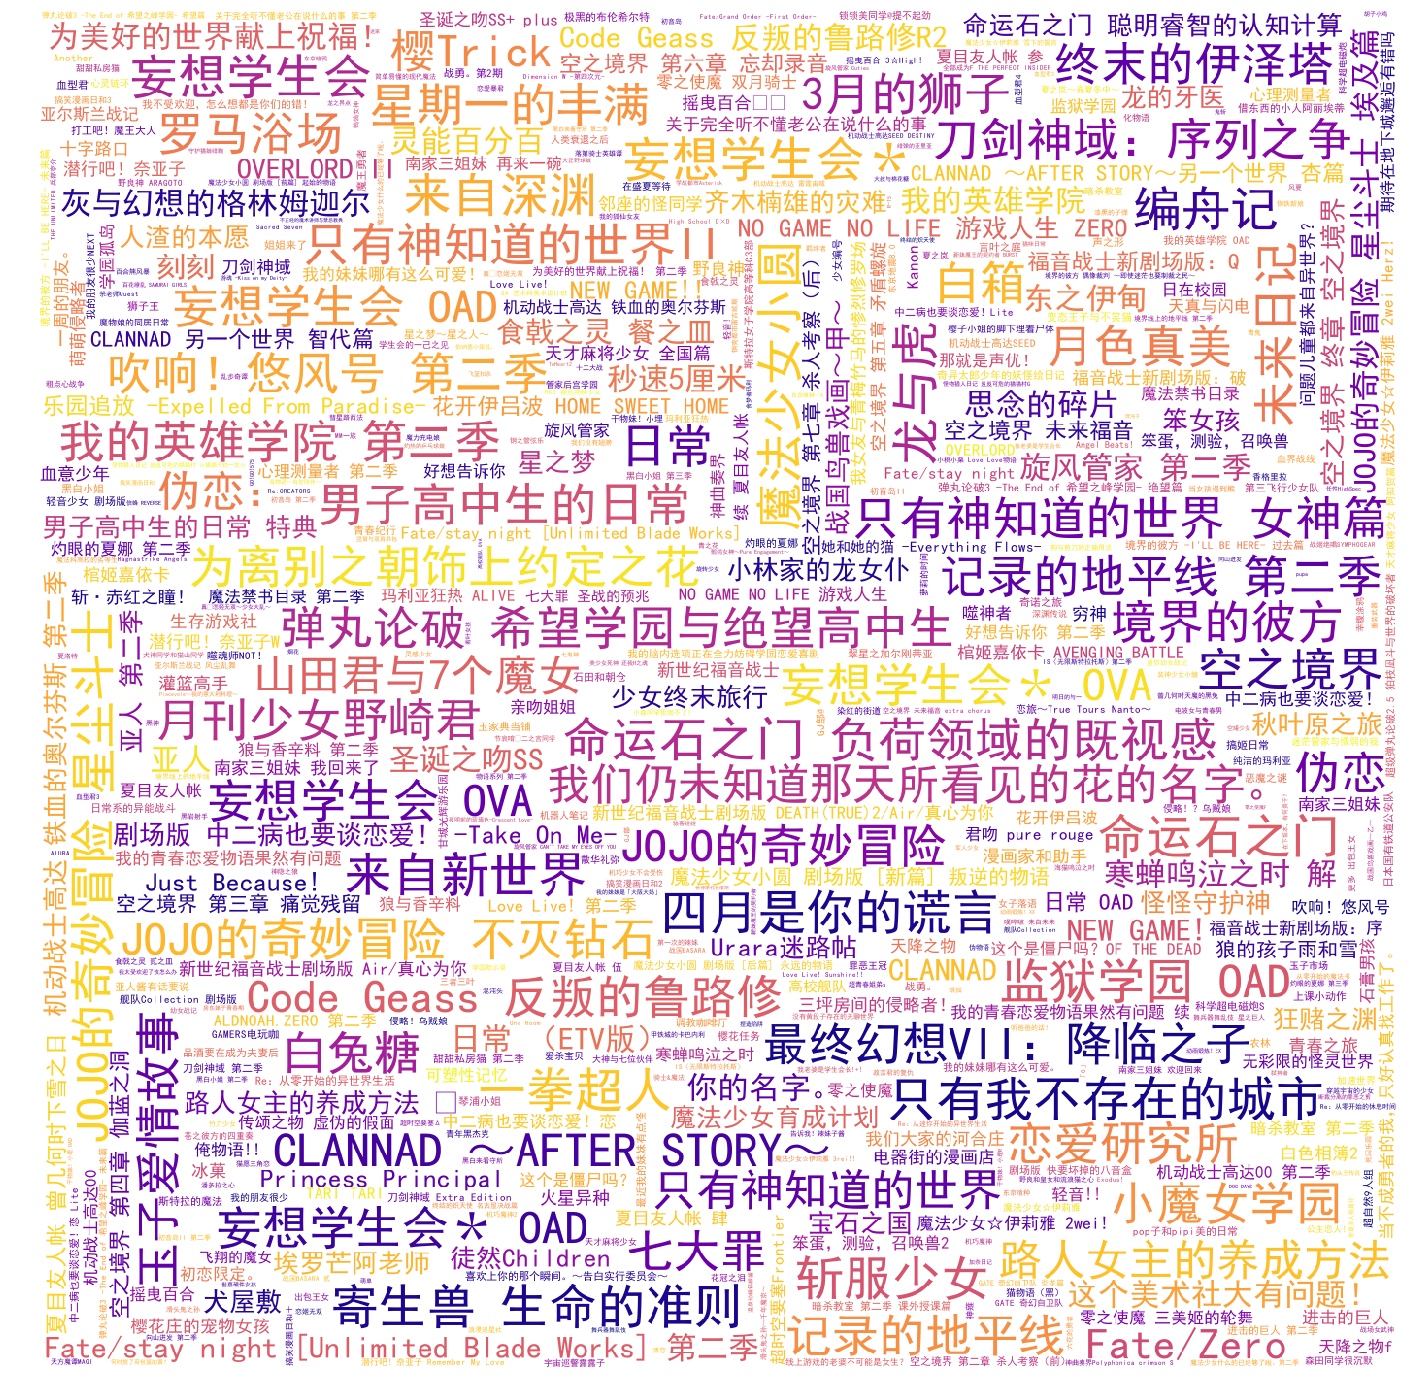

In [9]:
make_wordcloud_plot(df, 'chinese', 'star', colormap='plasma')

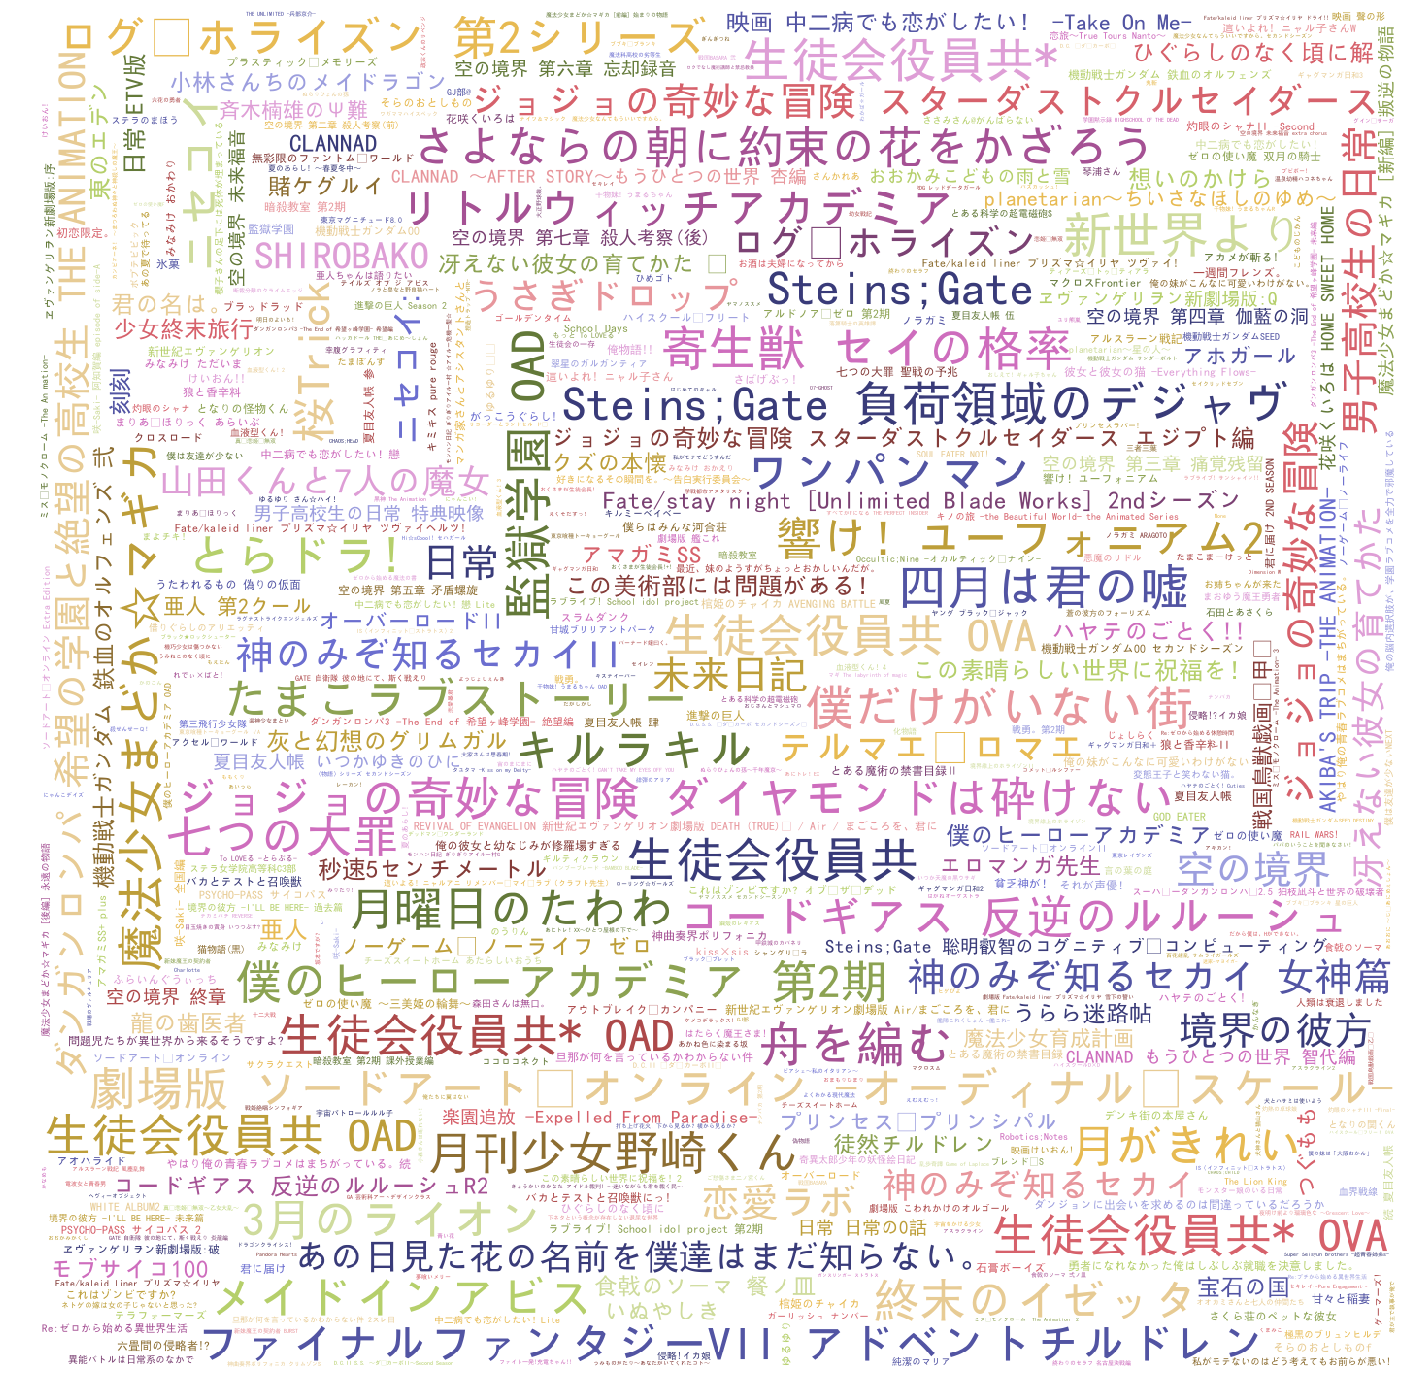

In [10]:
make_wordcloud_plot(df, 'japanese', 'star', colormap='tab20b')

## 评分分布

In [11]:
star_dist = df.groupby('star').count()
star_dist['percentage'] = round(star_dist.chinese/len(df)*100, 2)
star_dist['percentage'] = star_dist.percentage.apply(lambda x: str(x)+'%')
star_dist

chinese  japanese  link percentage
star                                    
4.0         6         6     6      1.01%
5.0        70        70    70      11.8%
6.0       122       122   122     20.57%
7.0       144       144   144     24.28%
8.0       158       158   158     26.64%
9.0        62        62    62     10.46%
10.0       16        16    16       2.7%

In [12]:
py.offline.init_notebook_mode(connected=True)

data = [go.Bar(
            x=star_dist.index,
            y=star_dist.chinese,
    text=star_dist.percentage
    )]

layout = go.Layout(
    title='评分分布情况',
    xaxis=dict(
        title='分数'
    ),
    yaxis=dict(
        title='动画部数'
    )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='jupyter/basic_bar')

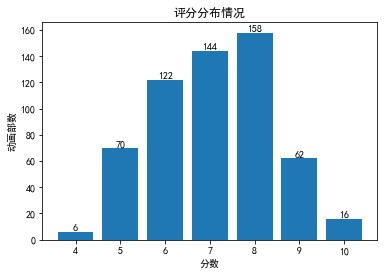

In [13]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 
plt.bar(star_dist.index, star_dist.chinese)

plt.ylabel('动画部数')
plt.xlabel('分数')
plt.title('评分分布情况')
plt.rcParams['figure.figsize'] = [15,5]

for a,b in zip(star_dist.index, star_dist.chinese):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom')
    
plt.show()

## Tag分析
### 1. 相关函数

In [14]:
def get_tag(url):
    content = get_html_content_in_text(url)
    soup = BeautifulSoup(content, "html5lib")
    step1 = soup.find_all('div',{'class':'inner'})
    tagList = []
    for i in step1:
        step2 = i.find_all('a', {'class':'l'})
        if len(step2) != 0:
            for j in step2:
                tagList.append(j.find('span').string)
    print('*', end='')
    try:
        return ','.join(tagList)
    except TypeError:
        return None

### 2. 拉取Tag数据
- 如果观看数很多，则需要耐心等待拉取完成

In [15]:
%%time
df['tag'] = df.link.apply(get_tag)

*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************Wall time: 19min 11s


In [25]:
# 为了重新运行时候不重新拉取Tag数据，保存起来
# df.to_csv('bangumi_report_log.csv', sep='|')
test_df = pd.read_csv('bangumi_report_log.csv', sep='|')
test_df.head(10)

Unnamed: 0                     chinese  \
0           0                 OVERLORD II   
1           1                    食戟之灵 餐之皿   
2           2               pop子和pipi美的日常   
3           3                          刻刻   
4           4                 为离别之朝饰上约定之花   
5           5  剧场版 中二病也要谈恋爱！ -Take On Me-   
6           6                        奇诺之旅   
7           7                     干物妹！小埋R   
8           8                      少女周末授课   
9           9               Just Because!   

                                         japanese  \
0                                       オーバーロードII   
1                                      食戟のソーマ 餐ノ皿   
2                                         ポプテピピック   
3                                              刻刻   
4                                さよならの朝に約束の花をかざろう   
5                     映画 中二病でも恋がしたい！ -Take On Me-   
6  キノの旅 -the Beautiful World- the Animated Series   
7                                    干物妹! うまるちゃんR   
8                                          少女週末授業   
9                                            None   

                               link  star  \
0  http://bangumi.tv/subject/211027   8.0   
1  http://bangumi.tv/subject/217632   8.0   
2  http://bangumi.tv/subject/212279   7.0   
3  http://bangumi.tv/subject/228026   8.0   
4  http://bangumi.tv/subject/218971   9.0   
5  http://bangumi.tv/subject/215425   8.0   
6  http://bangumi.tv/subject/211068   7.0   
7  http://bangumi.tv/subject/212775   5.0   
8  http://bangumi.tv/subject/227245   NaN   
9  http://bangumi.tv/subject/212278   8.0   

                                                 tag  
0  2018年1月,骨傲天,MADHouse,轻小说改,OVERLORD,TV,装逼,穿越,轻改...  
1  2017年10月,J.C.STAFF,漫画改,美食,TV,食戟之灵,热血,2017,校园,搞...  
2  2018年1月,神風動画,TV,搞笑,漫画改,霸权,pop子和pipi美的日常,漫改,201...  
3  2018年1月,TV,Genostudio,梅津泰臣,漫改,漫画改,悬疑,刻刻,2018,安...  
4  剧场版,P.A.WORKS,岡田麿里,原创,2018,2018年2月,川井憲次,动画电影,東...  
5  剧场版,京阿尼,中二病也要谈恋爱,2018,2018年1月,恋爱,京都动画,校园,原创动画,...  
6  2017年10月,轻小说改,Lerche,TV,公路片,悠木碧,奇幻,有生之年,2017,成...  
7  2017年10月,动画工房,日常,搞笑,漫画改,TV,干物妹！小埋,萌,续作,漫改,2017...  
8  泡面番,2017年10月,WEB,小剧场,少女周末授课,STUDIOPUYUKAI,漫画改,...  
9  2017年10月,原创,恋爱,鸭志田一,TV,比村奇石,校园,PINEJAM,2017,比村...

### 3. 统计

In [16]:
tag_list = df.tag.str.split(',').tolist()
tag_list = [x for x in tag_list if x is not None]
newlist = sum(tag_list, [])

tag_count = pd.Series(newlist).value_counts().to_frame().reset_index()
tag_count.columns = ['tag', 'count_']
tag_count.head(10)

tag  count_
0   TV     513
1   搞笑     286
2  漫画改     258
3   漫改     251
4   校园     227
5   动画     209
6   日本     187
7   治愈     186
8   奇幻     175
9   日常     175

In [17]:
column_count = 30
data = [go.Bar(
            x=tag_count.head(column_count).tag,
            y=tag_count.head(column_count).count_
    )]

layout = go.Layout(
    title='标签计数情况',
#     xaxis=dict(
#         title='分数'
#     ),
    yaxis=dict(
        title='标签总数'
    )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='jupyter/basic_bar')

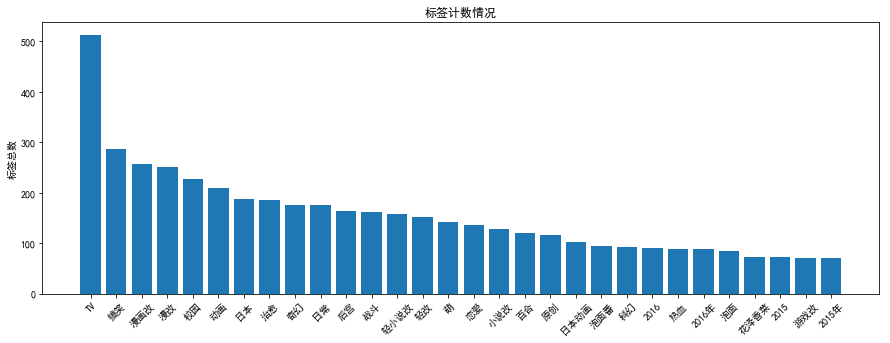

In [18]:
plt.bar(tag_count.head(column_count).tag, tag_count.head(column_count).count_)

plt.ylabel('标签总数')
# plt.xlabel('标签')
plt.xticks(rotation=45)
plt.title('标签计数情况')
plt.rcParams['figure.figsize'] = [15,5]
    
plt.show()

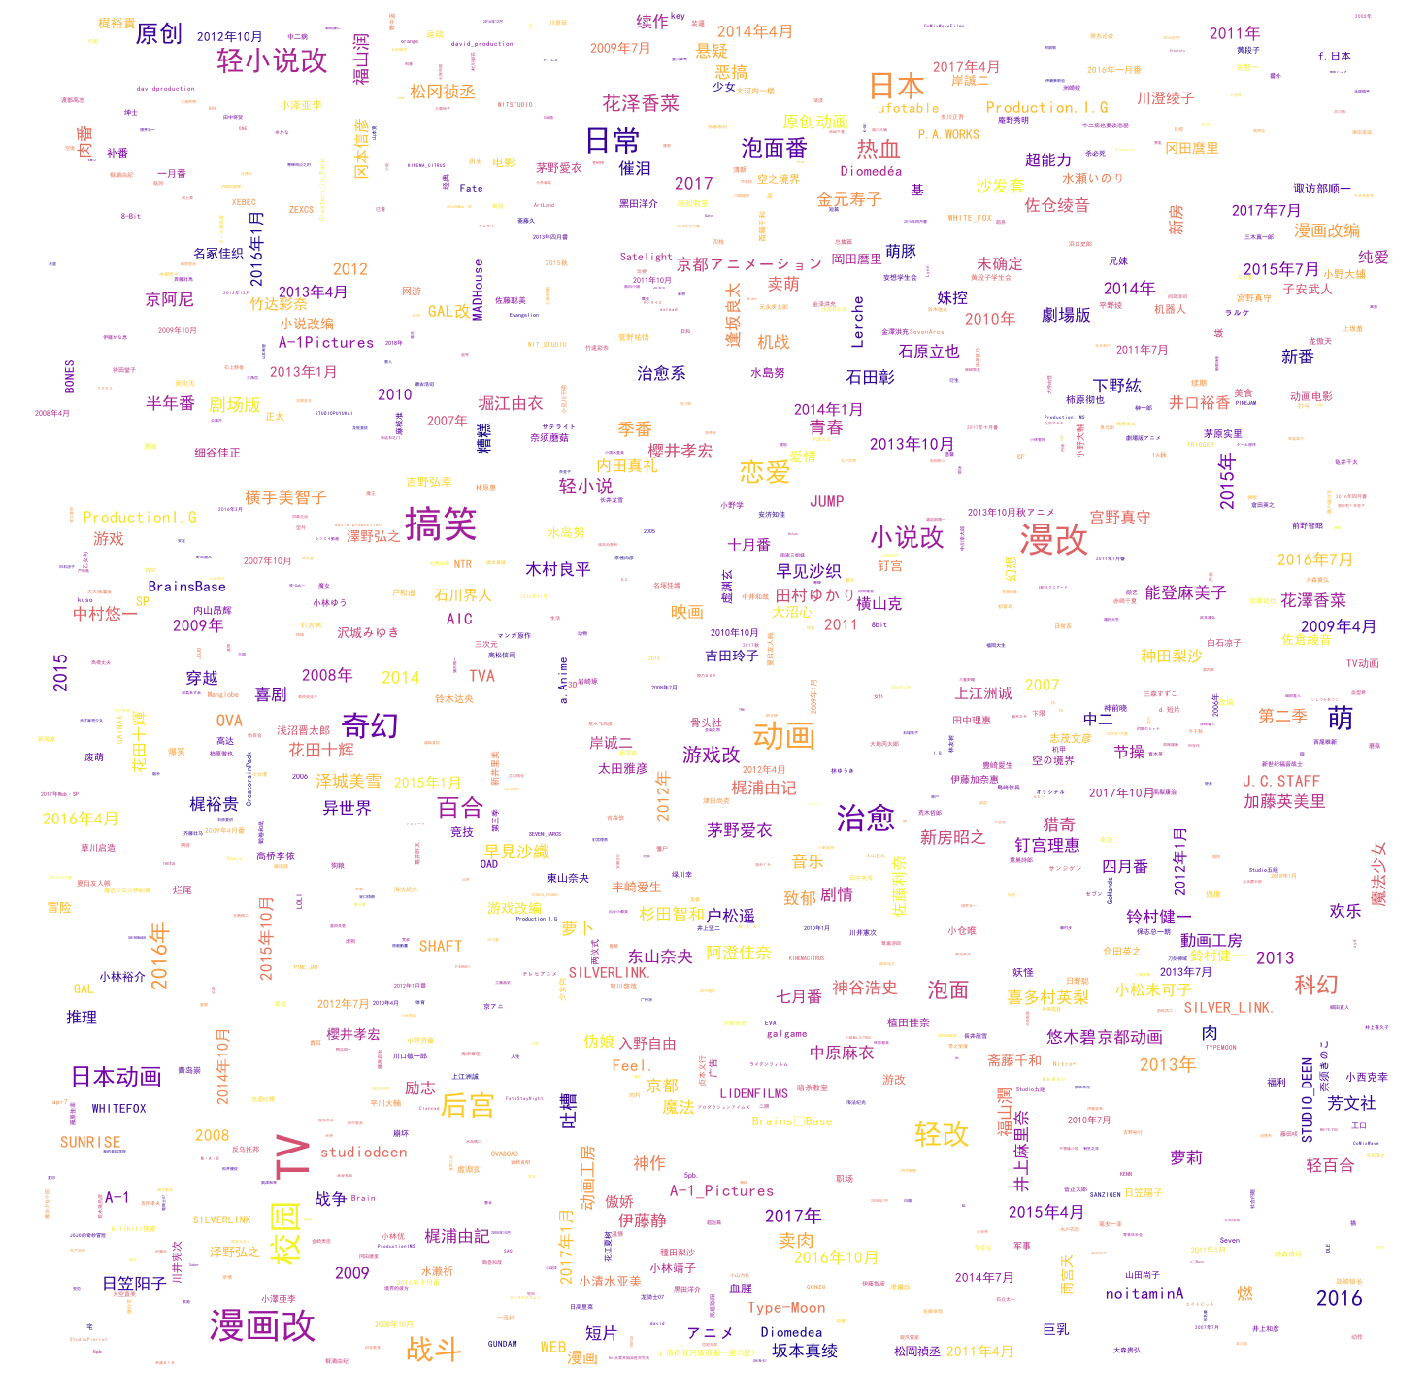

In [19]:
make_wordcloud_plot(tag_count, 'tag', 'count_', colormap='plasma',max_font_size=None)

In [98]:
season = tag_count[tag_count.tag.str.contains('^\d{4}年\d{1,2}月$')]
season = season.copy() # Avoid warning
season['date'] = pd.to_datetime(season.tag, format='%Y年%m月', errors='ignore')
season['year'] = season.tag.str.extract('^(\d{4})年', expand=True)
season['month'] = season.date.dt.month
conditions = [
    (season['month'] == 12) | (season['month'] == 1) | (season['month'] == 2),
    (season['month'] == 3) | (season['month'] == 4) | (season['month'] == 5),
    (season['month'] == 6) | (season['month'] == 7) | (season['month'] == 8),
    (season['month'] == 9) | (season['month'] == 10) | (season['month'] == 11)]
choices = ['Winter', 'Spring', 'Summer', 'Autumn']
season['season'] = np.select(conditions, choices, default='UnKnown')

season.head(5)

tag  count_       date  year  month  season
75   2016年10月      30 2016-10-01  2016     10  Autumn
83    2017年1月      28 2017-01-01  2017      1  Winter
115   2016年4月      21 2016-04-01  2016      4  Spring
117  2015年10月      21 2015-10-01  2015     10  Autumn
124   2016年1月      20 2016-01-01  2016      1  Winter

In [125]:
season['count_'].sum()

641

In [129]:
season_for_plot = season.groupby(['year', 'season']).sum()
# Adding missing group information
season_index = pd.MultiIndex.from_product(season_for_plot.index.levels, names=season_for_plot.index.names)
season_for_plot = season_for_plot.reindex(season_index).reset_index()
# Seasons as columns
table = pd.pivot_table(season_for_plot, values='count_', index=['season'], columns=['year'])
table = table.reindex(['Winter', 'Spring', 'Summer', 'Autumn'])
table

year    1993  1995  1997  1998  2001  2002  2003  2004  2005  2006  ...   \
season                                                              ...    
Winter   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   1.0  ...    
Spring   NaN   NaN   NaN   1.0   1.0   NaN   NaN   NaN   NaN   1.0  ...    
Summer   NaN   NaN   1.0   NaN   NaN   NaN   1.0   NaN   1.0   3.0  ...    
Autumn   1.0   1.0   NaN   NaN   NaN   1.0   NaN   1.0   4.0   3.0  ...    

year    2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  
season                                                              
Winter   7.0   7.0   8.0  18.0  18.0  17.0  17.0  23.0  30.0   6.0  
Spring  20.0   5.0  15.0   9.0  17.0  19.0  19.0  25.0  17.0   NaN  
Summer  16.0   9.0  12.0  11.0  11.0  13.0  19.0  22.0  18.0   NaN  
Autumn   7.0  10.0   7.0  13.0  21.0  17.0  21.0  37.0  12.0   NaN  

[4 rows x 22 columns]

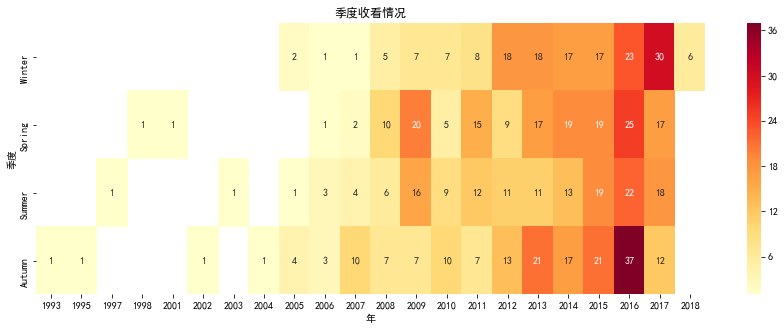

In [132]:
# plt.pcolor(table, cmap='YlOrRd')
# plt.xticks(np.arange(0.5, len(table.columns), 1), table.columns)
# plt.yticks(np.arange(0.5, len(table.index), 1), table.index)
####################
import seaborn as sns
sns.heatmap(table, cmap='YlOrRd', annot=True)
plt.ylabel('季度')
plt.xlabel('年')
plt.title('季度收看情况')
plt.show()

In [21]:
column_count = 50
data = [go.Bar(
            x=season.head(column_count).tag,
            y=season.head(column_count).count_
    )]

layout = go.Layout(
    title='季度收看情况',
    xaxis=dict(
        tickangle=45
    ),
    yaxis=dict(
        title='部数'
    )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

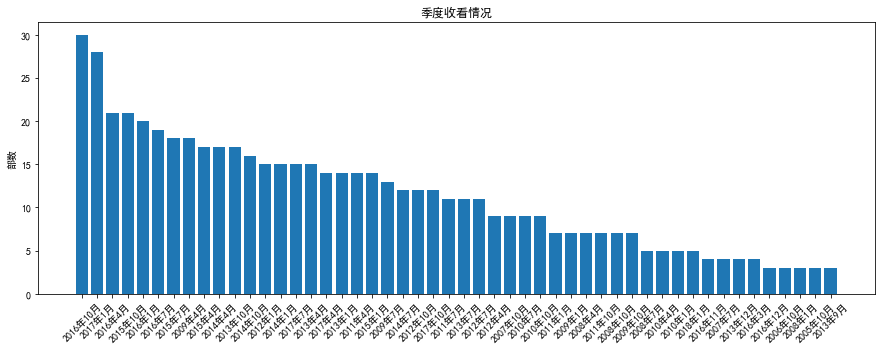

In [133]:
plt.bar(season.head(column_count).tag, season.head(column_count).count_)

plt.ylabel('部数')
# plt.xlabel('标签')
plt.xticks(rotation=45)
plt.title('季度收看情况')
plt.rcParams['figure.figsize'] = [15,5]
    
plt.show()